In [12]:
import torch.jit
import time
from argparse import ArgumentParser
import numpy as np
import torch
import os
import json

import dlrm.scripts.utils as utils
from dlrm.data.data_loader import get_data_loaders
from dlrm.data.utils import get_categorical_feature_sizes, prefetcher
from dlrm.model.single import Dlrm
from dlrm.utils.checkpointing.serial import SerialCheckpointWriter, make_serial_checkpoint_writer, \
    make_serial_checkpoint_loader

In [59]:
import pickle
with open('./assets/cat_mappings.pkl', 'rb') as f:
    cat_mappings=pickle.load(f)["cat_mappings"]

In [60]:
movies_mapping = cat_mappings['movieId_factor']

In [61]:
movies_mapping

Int64Index([   296,    306,    307,    665,    899,   1088,   1175,   1217,
              1237,   1250,
            ...
            200178, 200182, 200186, 200188, 200190, 200192, 200194, 139970,
            200726, 200728],
           dtype='int64', length=59047)

In [64]:
nn_to_movies = movies_mapping
movies_to_nn = {}
for i, val in enumerate(movies_mapping):    
    movies_to_nn[val] = i

In [65]:
nn_to_movies[0]

296

In [66]:
movies_to_nn[296]

0

In [18]:
class flag(object):
    def __init__(self):
        
        # Model configuration
        self.embedding_type = "joint" # The type of the embedding operation to use")
        self.embedding_dim = 128 # "Dimensionality of embedding space for categorical features")
        self.top_mlp_sizes = [128, 1] # "Linear layer sizes for the top MLP")
        self.bottom_mlp_sizes = [128, 128] #Linear layer sizes for the bottom MLP")

        self.interaction_op ="cuda_dot" #"Type of interaction operation to perform.")

        self.dataset = "./"
        self.dataset_type = "split" #The type of the dataset to use')

        self.base_device = "cuda" #"Device to run the majority of the model operations")
        self.amp = False #If True the script will use Automatic Mixed Precision")
        self.optimized_mlp = True #Use an optimized implementation of MLP from apex")
        self.max_table_size = None #Maximum number of rows per embedding table, by default equal to the number of unique values for each categorical variable")
        self.num_numerical_features = 171
        self.hash_indices = False

FLAGS = flag()

In [15]:

print("Creating model")

categorical_sizes_file = os.path.join("./model_size.json")
with open(categorical_sizes_file) as f:
    categorical_sizes = json.load(f).values()
categorical_sizes = list(categorical_sizes)
   
model_config = {
    'top_mlp_sizes': FLAGS.top_mlp_sizes,
    'bottom_mlp_sizes': FLAGS.bottom_mlp_sizes,
    'embedding_type': FLAGS.embedding_type,
    'embedding_dim': FLAGS.embedding_dim,
    'interaction_op': FLAGS.interaction_op,
    'categorical_feature_sizes': categorical_sizes,
    'num_numerical_features': FLAGS.num_numerical_features,
    'hash_indices': FLAGS.hash_indices,
    'use_cpp_mlp': FLAGS.optimized_mlp,
    'fp16': FLAGS.amp,
    'base_device': FLAGS.base_device,
}

model = Dlrm.from_dict(model_config)
print(model)

Creating model
Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 162541 221588 221724 223363 223365 223367 223369 223371 223373
       223375 223377 223379 223381 223383 223385 223387 223389 223391 223393
       223395 223397 223399 223401 223403]
      (embedding): Embedding(223403, 128)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [171, 128, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [429, 128], Bias=1, activation=1)
    )
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [20]:
checkpoint_loader = make_serial_checkpoint_loader(
            embedding_indices=range(len(get_categorical_feature_sizes(FLAGS))),
            device="cpu"
        )
checkpoint_loader.load_checkpoint(model, "../movie_lens_dlrm")
model.eval()
model.to(FLAGS.base_device)

feature sizes:  [162542, 59048, 137, 1640, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


/workspace/dlrm/dlrm/utils/checkpointing/model.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(array).to(self._device)


Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 162541 221588 221724 223363 223365 223367 223369 223371 223373
       223375 223377 223379 223381 223383 223385 223387 223389 223391 223393
       223395 223397 223399 223401 223403]
      (embedding): Embedding(223403, 128)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [171, 128, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [429, 128], Bias=1, activation=1)
    )
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [21]:
model.bottom_model.embeddings.embedding.weight.shape

torch.Size([223403, 128])

In [23]:
embedding = model.bottom_model.embeddings.embedding.weight.detach().cpu().numpy()

In [24]:
item_embedding = embedding[162541:162541+59047]
item_embedding.shape

(59047, 128)

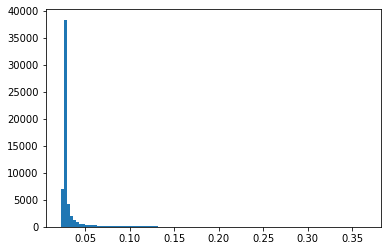

In [26]:
import matplotlib.pyplot as plt
plt.hist(np.linalg.norm(item_embedding, axis=1),100);

In [27]:
from scipy.spatial.distance import cdist
def find_similar_movies(nn_movie_id, item_embedding, k=10, metric='cosine'):
    sim = -cdist(item_embedding, item_embedding[nn_movie_id].reshape(1, -1), metric=metric)
    #sim = np.matmul(item_embedding, item_embedding[nn_movie_id].transpose())
    return sim.squeeze().argsort()[-k:][::-1]

In [48]:
import pandas as pd
movies = pd.read_csv("./data/ml-25m/movies.csv", index_col="movieId")
print(len(movies))


62423


In [38]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [67]:
movie_ID = 1 
print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

print("movies_to_nn[movie_ID]", movies_to_nn[movie_ID])
print("Similar movies: ")
similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)
print(similar_movies)

for i in similar_movies:
    if i==0:
        continue
    print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])

Query:  Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
movies_to_nn[movie_ID] 70
Similar movies: 
[  70  199  193  174 1891  652  151  187 2596   92]
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
4886 Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
3114 Toy Story 2 (1999) Adventure|Animation|Children|Comedy|Fantasy
673 Space Jam (1996) Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi
78499 Toy Story 3 (2010) Adventure|Animation|Children|Comedy|Fantasy|IMAX
2294 Antz (1998) Adventure|Animation|Children|Comedy|Fantasy
4016 Emperor's New Groove, The (2000) Adventure|Animation|Children|Comedy|Fantasy
661 James and the Giant Peach (1996) Adventure|Animation|Children|Fantasy|Musical
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical


In [68]:
for movie_ID in range(1000):
    try:
        print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

        print("Similar movies: ")
        similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

        for i in similar_movies:
            if i==0:
                continue
            print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])
        print('===============\n')
    except Exception as e:
        print(e)
        pass

0
Query:  Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
Similar movies: 
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
4886 Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
3114 Toy Story 2 (1999) Adventure|Animation|Children|Comedy|Fantasy
673 Space Jam (1996) Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi
78499 Toy Story 3 (2010) Adventure|Animation|Children|Comedy|Fantasy|IMAX
2294 Antz (1998) Adventure|Animation|Children|Comedy|Fantasy
4016 Emperor's New Groove, The (2000) Adventure|Animation|Children|Comedy|Fantasy
661 James and the Giant Peach (1996) Adventure|Animation|Children|Fantasy|Musical
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical

Query:  Jumanji (1995) Adventure|Children|Fantasy
Similar movies: 
2 Jumanji (1995) Adventure|Children|Fantasy
4896 Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (

18 Four Rooms (1995) Comedy
4015 Dude, Where's My Car? (2000) Comedy|Sci-Fi
1449 Waiting for Guffman (1996) Comedy
256 Junior (1994) Comedy|Sci-Fi
333 Tommy Boy (1995) Comedy
135 Down Periscope (1996) Comedy
3254 Wayne's World 2 (1993) Comedy
216 Billy Madison (1995) Comedy
743 Spy Hard (1996) Comedy
348 Bullets Over Broadway (1994) Comedy

Query:  Ace Ventura: When Nature Calls (1995) Comedy
Similar movies: 
19 Ace Ventura: When Nature Calls (1995) Comedy
344 Ace Ventura: Pet Detective (1994) Comedy
223 Clerks (1994) Comedy
104 Happy Gilmore (1996) Comedy
1485 Liar Liar (1997) Comedy
520 Robin Hood: Men in Tights (1993) Comedy
5 Father of the Bride Part II (1995) Comedy
141 Birdcage, The (1996) Comedy
2694 Big Daddy (1999) Comedy
2599 Election (1999) Comedy

Query:  Money Train (1995) Action|Comedy|Crime|Drama|Thriller
Similar movies: 
20 Money Train (1995) Action|Comedy|Crime|Drama|Thriller
145 Bad Boys (1995) Action|Comedy|Crime|Drama|Thriller
349 Clear and Present Danger (1994) Act

36 Dead Man Walking (1995) Crime|Drama
16 Casino (1995) Crime|Drama
318 Shawshank Redemption, The (1994) Crime|Drama
431 Carlito's Way (1993) Crime|Drama
3147 Green Mile, The (1999) Crime|Drama
1466 Donnie Brasco (1997) Crime|Drama
2329 American History X (1998) Crime|Drama
1213 Goodfellas (1990) Crime|Drama
3328 Ghost Dog: The Way of the Samurai (1999) Crime|Drama
4239 Blow (2001) Crime|Drama

Query:  Across the Sea of Time (1995) Documentary|IMAX
Similar movies: 
37 Across the Sea of Time (1995) Documentary|IMAX
149614 Worlds Apart (2015) Drama
136335 Scooby-Doo and the Alien Invaders (2000) Animation|Children
165567 Politexnitis and Erimospitis (1963) Comedy
87190 My Brother Talks to Horses (1947) Comedy
5045 Galaxina (1980) Comedy|Sci-Fi
188179 My Perfect Romance (2018) Romance
126552 Fort McCoy (2011) Drama|War
116728 Out of Bounds (2011) Drama
26026 Undead, The (1957) Fantasy|Horror

Query:  It Takes Two (1995) Children|Comedy
Similar movies: 
38 It Takes Two (1995) Children|Come

Similar movies: 
55 Georgia (1995) Drama
613 Jane Eyre (1996) Drama|Romance
1296 Room with a View, A (1986) Drama|Romance
3983 You Can Count on Me (2000) Drama|Romance
428 Bronx Tale, A (1993) Drama
491 Man Without a Face, The (1993) Drama
193 Showgirls (1995) Drama
1266 Unforgiven (1992) Drama|Western
535 Short Cuts (1993) Drama
2976 Bringing Out the Dead (1999) Drama

Query:  Kids of the Round Table (1995) Adventure|Children|Comedy|Fantasy
Similar movies: 
56 Kids of the Round Table (1995) Adventure|Children|Comedy|Fantasy
7097 Girl From Paris, A (hirondelle a fait le printemps, Une) (2001) Comedy|Drama
167046 When Saturday Comes (1996) Drama
135667 People of Rome (2003) (no genres listed)
3961 Ghoulies (1985) Horror
142544 Swap Meet (1979) (no genres listed)
118107 The Righteous Thief (2009) Adventure
145324 Twice Upon a Time (2006) Comedy
193003 David Blaine: Street Magic (1997) Documentary
4812 SpaceCamp (1986) Adventure|Sci-Fi

Query:  Home for the Holidays (1995) Drama
Similar m

73 Misérables, Les (1995) Drama|War
4008 Born on the Fourth of July (1989) Drama|War
1090 Platoon (1986) Drama|War
5995 Pianist, The (2002) Drama|War
1183 English Patient, The (1996) Drama|Romance|War
41 Richard III (1995) Drama|War
4223 Enemy at the Gates (2001) Drama|War
31410 Downfall (Untergang, Der) (2004) Drama|War
1222 Full Metal Jacket (1987) Drama|War
1242 Glory (1989) Drama|War

Query:  Bed of Roses (1996) Drama|Romance
Similar movies: 
74 Bed of Roses (1996) Drama|Romance
1357 Shine (1996) Drama|Romance
509 Piano, The (1993) Drama|Romance
515 Remains of the Day, The (1993) Drama|Romance
249 Immortal Beloved (1994) Drama|Romance
17 Sense and Sensibility (1995) Drama|Romance
25 Leaving Las Vegas (1995) Drama|Romance
3556 Virgin Suicides, The (1999) Drama|Romance
3978 Legend of Bagger Vance, The (2000) Drama|Romance
1059 William Shakespeare's Romeo + Juliet (1996) Drama|Romance

Query:  Big Bully (1996) Comedy|Drama
Similar movies: 
75 Big Bully (1996) Comedy|Drama
351 Corrina,

93 Vampire in Brooklyn (1995) Comedy|Horror|Romance
468 Englishman Who Went Up a Hill But Came Down a Mountain, The (1995) Comedy|Romance
3 Grumpier Old Men (1995) Comedy|Romance
417 Barcelona (1994) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
289 Only You (1994) Comedy|Romance
276 Milk Money (1994) Comedy|Romance
1441 Benny & Joon (1993) Comedy|Romance
180 Mallrats (1995) Comedy|Romance
7 Sabrina (1995) Comedy|Romance

Query:  Beautiful Girls (1996) Comedy|Drama|Romance
Similar movies: 
94 Beautiful Girls (1996) Comedy|Drama|Romance
224 Don Juan DeMarco (1995) Comedy|Drama|Romance
838 Emma (1996) Comedy|Drama|Romance
58 Postman, The (Postino, Il) (1994) Comedy|Drama|Romance
852 Tin Cup (1996) Comedy|Drama|Romance
372 Reality Bites (1994) Comedy|Drama|Romance
232 Eat Drink Man Woman (Yin shi nan nu) (1994) Comedy|Drama|Romance
361 It Could Happen to You (1994) Comedy|Drama|Romance
1537 Shall We Dance? (Shall We Dansu?) (1996) Comedy|Drama|Romance
52 Mighty Aphrodite (1995) Comedy|Dra

111 Taxi Driver (1976) Crime|Drama|Thriller
48516 Departed, The (2006) Crime|Drama|Thriller
44199 Inside Man (2006) Crime|Drama|Thriller
4034 Traffic (2000) Crime|Drama|Thriller
4776 Training Day (2001) Crime|Drama|Thriller
1729 Jackie Brown (1997) Crime|Drama|Thriller
115569 Nightcrawler (2014) Crime|Drama|Thriller
2268 Few Good Men, A (1992) Crime|Drama|Thriller
51540 Zodiac (2007) Crime|Drama|Thriller
55765 American Gangster (2007) Crime|Drama|Thriller

Query:  Rumble in the Bronx (Hont faan kui) (1995) Action|Adventure|Comedy|Crime
Similar movies: 
112 Rumble in the Bronx (Hont faan kui) (1995) Action|Adventure|Comedy|Crime
153 Batman Forever (1995) Action|Adventure|Comedy|Crime
4027 O Brother, Where Art Thou? (2000) Adventure|Comedy|Crime
119145 Kingsman: The Secret Service (2015) Action|Adventure|Comedy|Crime
101 Bottle Rocket (1996) Adventure|Comedy|Crime|Romance
91529 Dark Knight Rises, The (2012) Action|Adventure|Crime|IMAX
60074 Hancock (2008) Action|Adventure|Comedy|Crime|Fa

130 Angela (1995) Drama
126217 Delivery: The Beast Within (2013) Horror|Thriller
8906 Cannibal Holocaust (1980) Horror
151999 Beware of Christians (2011) Documentary
137543 Satan's Sadists (1969) Action|Drama|Thriller
7233 My Letter to George (Mesmerized) (1986) Drama
78093 Parisian Love (1925) Comedy|Crime|Drama|Romance
200380 Crossroads: One Two Jaga (2018) Action|Crime|Drama
123937 Five Loose Women (1974) Action|Adventure|Crime|Drama
43832 Call of Cthulhu, The (2005) Horror|Thriller

Query:  Frankie Starlight (1995) Drama|Romance
Similar movies: 
131 Frankie Starlight (1995) Drama|Romance
892 Twelfth Night (1996) Comedy|Drama|Romance
6003 Confessions of a Dangerous Mind (2002) Comedy|Crime|Drama|Thriller
608 Fargo (1996) Comedy|Crime|Drama|Thriller
6016 City of God (Cidade de Deus) (2002) Action|Adventure|Crime|Drama|Thriller
2171 Next Stop Wonderland (1998) Comedy|Drama|Romance
866 Bound (1996) Crime|Drama|Romance|Thriller
8689 Shock to the System, A (1990) Comedy|Crime|Thriller
34

147 Basketball Diaries, The (1995) Drama
282 Nell (1994) Drama
306 Three Colors: Red (Trois couleurs: Rouge) (1994) Drama
508 Philadelphia (1993) Drama
193 Showgirls (1995) Drama
307 Three Colors: Blue (Trois couleurs: Bleu) (1993) Drama
524 Rudy (1993) Drama
337 What's Eating Gilbert Grape (1993) Drama
300 Quiz Show (1994) Drama
2541 Cruel Intentions (1999) Drama

Query:  Awfully Big Adventure, An (1995) Drama
Similar movies: 
148 Awfully Big Adventure, An (1995) Drama
7042 Betty Blue (37°2 le matin) (1986) Drama|Romance
39381 Proposition, The (2005) Crime|Drama|Western
6223 Spun (2001) Comedy|Crime|Drama
299 Priest (1994) Drama
167196 1. Mai (2008) Drama
1542 Brassed Off (1996) Comedy|Drama|Romance
175969 Leslie Caron: The Reluctant Star (2016) Documentary
89936 Corruption (1968) Horror
121015 Pasha (1968) Crime|Drama

Query:  Amateur (1994) Crime|Drama|Thriller
Similar movies: 
149 Amateur (1994) Crime|Drama|Thriller
1245 Miller's Crossing (1990) Crime|Drama|Film-Noir|Thriller
482 K

165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller
185 Net, The (1995) Action|Crime|Thriller
288 Natural Born Killers (1994) Action|Crime|Thriller
6 Heat (1995) Action|Crime|Thriller
2278 Ronin (1998) Action|Crime|Thriller
592 Batman (1989) Action|Crime|Thriller
4369 Fast and the Furious, The (2001) Action|Crime|Thriller
1036 Die Hard (1988) Action|Crime|Thriller
6874 Kill Bill: Vol. 1 (2003) Action|Crime|Thriller
54286 Bourne Ultimatum, The (2007) Action|Crime|Thriller

Query:  Doom Generation, The (1995) Comedy|Crime|Drama
Similar movies: 
166 Doom Generation, The (1995) Comedy|Crime|Drama
2289 Player, The (1992) Comedy|Crime|Drama
778 Trainspotting (1996) Comedy|Crime|Drama
2973 Crimes and Misdemeanors (1989) Comedy|Crime|Drama
1271 Fried Green Tomatoes (1991) Comedy|Crime|Drama
3130 Bonfire of the Vanities (1990) Comedy|Crime|Drama
290 Once Were Warriors (1994) Crime|Drama
5991 Chicago (2002) Comedy|Crime|Drama|Musical
6708 Matchstick Men (2003) Comedy|Crime|Drama
16 Casin

205963 Skaterdater (1966) Drama|Romance

Query:  Net, The (1995) Action|Crime|Thriller
Similar movies: 
185 Net, The (1995) Action|Crime|Thriller
165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller
288 Natural Born Killers (1994) Action|Crime|Thriller
6 Heat (1995) Action|Crime|Thriller
2278 Ronin (1998) Action|Crime|Thriller
4369 Fast and the Furious, The (2001) Action|Crime|Thriller
592 Batman (1989) Action|Crime|Thriller
3744 Shaft (2000) Action|Crime|Thriller
1036 Die Hard (1988) Action|Crime|Thriller
6874 Kill Bill: Vol. 1 (2003) Action|Crime|Thriller

Query:  Nine Months (1995) Comedy|Romance
Similar movies: 
186 Nine Months (1995) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
497 Much Ado About Nothing (1993) Comedy|Romance
3 Grumpier Old Men (1995) Comedy|Romance
180 Mallrats (1995) Comedy|Romance
708 Truth About Cats & Dogs, The (1996) Comedy|Romance
1441 Benny & Joon (1993) Comedy|Romance
7 Sabrina (1995) Comedy|Romance
276 Milk Money (1994) Comedy|Romance
440 Dave (1

203 To Wong Foo, Thanks for Everything! Julie Newmar (1995) Comedy
1020 Cool Runnings (1993) Comedy
1449 Waiting for Guffman (1996) Comedy
256 Junior (1994) Comedy|Sci-Fi
743 Spy Hard (1996) Comedy
3450 Grumpy Old Men (1993) Comedy
663 Kids in the Hall: Brain Candy (1996) Comedy
435 Coneheads (1993) Comedy|Sci-Fi
719 Multiplicity (1996) Comedy
830 First Wives Club, The (1996) Comedy

Query:  Under Siege 2: Dark Territory (1995) Action
Similar movies: 
204 Under Siege 2: Dark Territory (1995) Action
9 Sudden Death (1995) Action
2641 Superman II (1980) Action|Sci-Fi
3698 Running Man, The (1987) Action|Sci-Fi
1304 Butch Cassidy and the Sundance Kid (1969) Action|Western
1379 Young Guns II (1990) Action|Western
37386 Aeon Flux (2005) Action|Sci-Fi
2533 Escape from the Planet of the Apes (1971) Action|Sci-Fi
1373 Star Trek V: The Final Frontier (1989) Action|Sci-Fi
4866 Last Castle, The (2001) Action

Query:  Unstrung Heroes (1995) Comedy|Drama
Similar movies: 
205 Unstrung Heroes (1995) Co

225 Disclosure (1994) Drama|Thriller
454 Firm, The (1993) Drama|Thriller
3755 Perfect Storm, The (2000) Drama|Thriller
805 Time to Kill, A (1996) Drama|Thriller
3006 Insider, The (1999) Drama|Thriller
3409 Final Destination (2000) Drama|Thriller
3510 Frequency (2000) Drama|Thriller
4235 Amores Perros (Love's a Bitch) (2000) Drama|Thriller
7254 The Butterfly Effect (2004) Drama|Sci-Fi|Thriller
230 Dolores Claiborne (1995) Drama|Thriller

Query:  Dream Man (1995) Thriller
Similar movies: 
226 Dream Man (1995) Thriller
173143 Maigrets Night at the Crossroads (2017) Crime|Mystery|Thriller
185179 Born to Fly: Elizabeth Streb vs. Gravity (2014) Documentary
201418 Friends Forever (1987) Drama
148202 The Shark Hunter (1979) Adventure
6148 White Dog (1982) Drama|Horror|Thriller
97234 Inside: 'Dr. Strangelove or How I Learned to Stop Worrying and Love the Bomb' (2000) Documentary
115889 Deal, The (2007) Action|Comedy|Thriller
131072 Jesus liebt mich (2012) Comedy
146214 Septic Man (2013) Horror


243 Gordy (1995) Children|Comedy|Fantasy
2606 Idle Hands (1999) Comedy|Horror
2330 Hands on a Hard Body (1996) Comedy|Documentary
842 Tales from the Crypt Presents: Bordello of Blood (1996) Comedy|Horror
289 Only You (1994) Comedy|Romance
1241 Dead Alive (Braindead) (1992) Comedy|Fantasy|Horror
3018 Re-Animator (1985) Comedy|Horror|Sci-Fi
2772 Detroit Rock City (1999) Comedy
489 Made in America (1993) Comedy
4149 Saving Silverman (Evil Woman) (2001) Comedy|Romance

Query:  Gumby: The Movie (1995) Animation|Children
Similar movies: 
244 Gumby: The Movie (1995) Animation|Children
2137 Charlotte's Web (1973) Animation|Children
8372 Garfield: The Movie (2004) Animation|Children|Comedy
616 Aristocats, The (1970) Animation|Children
3213 Batman: Mask of the Phantasm (1993) Animation|Children
3483 Road to El Dorado, The (2000) Animation|Children
4090 Brave Little Toaster, The (1987) Animation|Children
313 Swan Princess, The (1994) Animation|Children
3799 Pokémon the Movie 2000 (2000) Animation

262 Little Princess, A (1995) Children|Drama
531 Secret Garden, The (1993) Children|Drama
34 Babe (1995) Children|Drama
1097 E.T. the Extra-Terrestrial (1982) Children|Drama|Sci-Fi
1012 Old Yeller (1957) Children|Drama
27 Now and Then (1995) Children|Drama
953 It's a Wonderful Life (1946) Children|Drama|Fantasy|Romance
3189 My Dog Skip (1999) Children|Drama
1302 Field of Dreams (1989) Children|Drama|Fantasy
90866 Hugo (2011) Children|Drama|Mystery

Query:  Ladybird Ladybird (1994) Drama
Similar movies: 
263 Ladybird Ladybird (1994) Drama
2393 Star Trek: Insurrection (1998) Action|Drama|Romance|Sci-Fi
249 Immortal Beloved (1994) Drama|Romance
381 When a Man Loves a Woman (1994) Drama|Romance
74 Bed of Roses (1996) Drama|Romance
168 First Knight (1995) Action|Drama|Romance
2025 Lolita (1997) Drama|Romance
1059 William Shakespeare's Romeo + Juliet (1996) Drama|Romance
215 Before Sunrise (1995) Drama|Romance
2269 Indecent Proposal (1993) Drama|Romance

Query:  Enfer, L' (1994) Drama
Simila

280 Murder in the First (1995) Drama|Thriller
225 Disclosure (1994) Drama|Thriller
230 Dolores Claiborne (1995) Drama|Thriller
79 Juror, The (1996) Drama|Thriller
3409 Final Destination (2000) Drama|Thriller
805 Time to Kill, A (1996) Drama|Thriller
3510 Frequency (2000) Drama|Thriller
1876 Deep Impact (1998) Drama|Sci-Fi|Thriller
454 Firm, The (1993) Drama|Thriller
3006 Insider, The (1999) Drama|Thriller

Query:  Nobody's Fool (1994) Comedy|Drama|Romance
Similar movies: 
281 Nobody's Fool (1994) Comedy|Drama|Romance
224 Don Juan DeMarco (1995) Comedy|Drama|Romance
232 Eat Drink Man Woman (Yin shi nan nu) (1994) Comedy|Drama|Romance
58 Postman, The (Postino, Il) (1994) Comedy|Drama|Romance
52 Mighty Aphrodite (1995) Comedy|Drama|Romance
372 Reality Bites (1994) Comedy|Drama|Romance
838 Emma (1996) Comedy|Drama|Romance
1409 Michael (1996) Comedy|Drama|Fantasy|Romance
361 It Could Happen to You (1994) Comedy|Drama|Romance
852 Tin Cup (1996) Comedy|Drama|Romance

Query:  Nell (1994) Drama

301 Picture Bride (Bijo photo) (1994) Drama|Romance
70599 Time Traveler's Wife, The (2009) Drama|Romance|Sci-Fi
446 Farewell My Concubine (Ba wang bie ji) (1993) Drama|Romance
1678 Joy Luck Club, The (1993) Drama|Romance
26903 Whisper of the Heart (Mimi wo sumaseba) (1995) Animation|Drama|Romance
7669 Pride and Prejudice (1995) Drama|Romance
59 Confessional, The (Confessionnal, Le) (1995) Drama|Mystery
2269 Indecent Proposal (1993) Drama|Romance
110730 Transcendence (2014) Drama|Sci-Fi|IMAX
300 Quiz Show (1994) Drama

Query:  Queen Margot (Reine Margot, La) (1994) Drama|Romance
Similar movies: 
302 Queen Margot (Reine Margot, La) (1994) Drama|Romance
222 Circle of Friends (1995) Drama|Romance
515 Remains of the Day, The (1993) Drama|Romance
534 Shadowlands (1993) Drama|Romance
446 Farewell My Concubine (Ba wang bie ji) (1993) Drama|Romance
249 Immortal Beloved (1994) Drama|Romance
105 Bridges of Madison County, The (1995) Drama|Romance
2269 Indecent Proposal (1993) Drama|Romance
381 Wh

322 Swimming with Sharks (1995) Comedy|Drama
765 Jack (1996) Comedy|Drama
562 Welcome to the Dollhouse (1995) Comedy|Drama
235 Ed Wood (1994) Comedy|Drama
1060 Swingers (1996) Comedy|Drama
272 Madness of King George, The (1994) Comedy|Drama
500 Mrs. Doubtfire (1993) Comedy|Drama
345 Adventures of Priscilla, Queen of the Desert, The (1994) Comedy|Drama
1042 That Thing You Do! (1996) Comedy|Drama
1476 Private Parts (1997) Comedy|Drama

323
Query:  Sum of Us, The (1994) Comedy|Drama
Similar movies: 
324 Sum of Us, The (1994) Comedy|Drama
542 Son in Law (1993) Comedy|Drama|Romance
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
179 Mad Love (1995) Drama|Romance
90249 Real Steel (2011) Action|Drama|Sci-Fi|IMAX
458 Geronimo: An American Legend (1993) Drama|Western
714 Dead Man (1995) Drama|Mystery|Western
3269 Forever Young (1992) Drama|Romance|Sci-Fi
1542 Brassed Off (1996) Comedy|Drama|Romance
1726 Postman, The (1997) Action|Adventure|Drama|Sci-Fi

Query:  Nationa

342 Muriel's Wedding (1994) Comedy
471 Hudsucker Proxy, The (1994) Comedy
216 Billy Madison (1995) Comedy
223 Clerks (1994) Comedy
344 Ace Ventura: Pet Detective (1994) Comedy
19 Ace Ventura: When Nature Calls (1995) Comedy
104 Happy Gilmore (1996) Comedy
141 Birdcage, The (1996) Comedy
520 Robin Hood: Men in Tights (1993) Comedy
348 Bullets Over Broadway (1994) Comedy

Query:  Baby-Sitters Club, The (1995) Children
Similar movies: 
343 Baby-Sitters Club, The (1995) Children
2091 Return from Witch Mountain (1978) Children|Sci-Fi
2034 Black Hole, The (1979) Children|Sci-Fi
2804 Christmas Story, A (1983) Children|Comedy
2059 Parent Trap, The (1998) Children|Comedy|Romance
1707 Home Alone 3 (1997) Children|Comedy
4700 Princess Diaries, The (2001) Children|Comedy|Romance
1713 Mouse Hunt (1997) Children|Comedy
2082 Mighty Ducks, The (1992) Children|Comedy
4386 Cats & Dogs (2001) Children|Comedy

Query:  Ace Ventura: Pet Detective (1994) Comedy
Similar movies: 
344 Ace Ventura: Pet Detective

360 I Love Trouble (1994) Action|Comedy
3972 Legend of Drunken Master, The (Jui kuen II) (1994) Action|Comedy
2701 Wild Wild West (1999) Action|Comedy|Sci-Fi|Western
370 Naked Gun 33 1/3: The Final Insult (1994) Action|Comedy
1391 Mars Attacks! (1996) Action|Comedy|Sci-Fi
94777 Men in Black III (M.III.B.) (M.I.B.³) (2012) Action|Comedy|Sci-Fi|IMAX
327 Tank Girl (1995) Action|Comedy|Sci-Fi
1431 Beverly Hills Ninja (1997) Action|Comedy
236 French Kiss (1995) Action|Comedy|Romance
1378 Young Guns (1988) Action|Comedy|Western

Query:  It Could Happen to You (1994) Comedy|Drama|Romance
Similar movies: 
361 It Could Happen to You (1994) Comedy|Drama|Romance
58 Postman, The (Postino, Il) (1994) Comedy|Drama|Romance
372 Reality Bites (1994) Comedy|Drama|Romance
852 Tin Cup (1996) Comedy|Drama|Romance
52 Mighty Aphrodite (1995) Comedy|Drama|Romance
838 Emma (1996) Comedy|Drama|Romance
11 American President, The (1995) Comedy|Drama|Romance
232 Eat Drink Man Woman (Yin shi nan nu) (1994) Comedy|D

378 Speechless (1994) Comedy|Romance
468 Englishman Who Went Up a Hill But Came Down a Mountain, The (1995) Comedy|Romance
180 Mallrats (1995) Comedy|Romance
7 Sabrina (1995) Comedy|Romance
237 Forget Paris (1995) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
1441 Benny & Joon (1993) Comedy|Romance
276 Milk Money (1994) Comedy|Romance
417 Barcelona (1994) Comedy|Romance
2558 Forces of Nature (1999) Comedy|Romance

Query:  Timecop (1994) Action|Sci-Fi|Thriller
Similar movies: 
379 Timecop (1994) Action|Sci-Fi|Thriller
5903 Equilibrium (2002) Action|Sci-Fi|Thriller
172 Johnny Mnemonic (1995) Action|Sci-Fi|Thriller
8371 Chronicles of Riddick, The (2004) Action|Sci-Fi|Thriller
3986 6th Day, The (2000) Action|Sci-Fi|Thriller
1882 Godzilla (1998) Action|Sci-Fi|Thriller
2600 eXistenZ (1999) Action|Sci-Fi|Thriller
748 Arrival, The (1996) Action|Sci-Fi|Thriller
303 Quick and the Dead, The (1995) Action|Thriller|Western
3697 Predator 2 (1990) Action|Sci-Fi|Thriller

Query:  True Lies (1994) Acti

397 Fear, The (1995) Horror
63692 Don Q Son of Zorro (1925) Adventure|Romance
198355 The Dizzy Acrobat (1943) Animation
155683 I arhontissa ki o alitis (1968) Comedy|Drama
174481 Strong Island (2017) Documentary
133657 Pédale douce (1996) Comedy
171815 Wrath of the Crows (2013) Horror|Mystery|Thriller
184003 Heroine (no genres listed)
160062 The Electric Chair (1969) Crime|Drama
130914 Savage Weekend (1979) Horror

Query:  Frank and Ollie (1995) Documentary
Similar movies: 
398 Frank and Ollie (1995) Documentary
90514 Blondie Knows Best (1946) Comedy
95767 Power (Jew Süss) (1934) Drama|Romance
133119 Raised by Wolves (2014) Horror
151849 The Company's in Love (1932) Comedy
70611 Traffic Affairs (Mitfahrer) (2004) Drama
147631 Afraid to Die (1960) Action|Drama
32689 Reuben, Reuben (1983) Comedy|Drama|Romance
170591 DMB (2000) Comedy
142370 We Are the Freaks (2014) Comedy

Query:  Girl in the Cadillac (1995) Drama
Similar movies: 
399 Girl in the Cadillac (1995) Drama
793 My Life and Tim

417 Barcelona (1994) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
3 Grumpier Old Men (1995) Comedy|Romance
1441 Benny & Joon (1993) Comedy|Romance
180 Mallrats (1995) Comedy|Romance
2805 Mickey Blue Eyes (1999) Comedy|Romance
276 Milk Money (1994) Comedy|Romance
7 Sabrina (1995) Comedy|Romance
237 Forget Paris (1995) Comedy|Romance
468 Englishman Who Went Up a Hill But Came Down a Mountain, The (1995) Comedy|Romance

Query:  Being Human (1993) Drama
Similar movies: 
418 Being Human (1993) Drama
242 Farinelli: il castrato (1994) Drama|Musical
302 Queen Margot (Reine Margot, La) (1994) Drama|Romance
207 Walk in the Clouds, A (1995) Drama|Romance
3156 Bicentennial Man (1999) Drama|Romance|Sci-Fi
347 Bitter Moon (1992) Drama|Film-Noir|Romance
1464 Lost Highway (1997) Crime|Drama|Fantasy|Film-Noir|Mystery|Romance
4144 In the Mood For Love (Fa yeung nin wa) (2000) Drama|Romance
3824 Autumn in New York (2000) Drama|Romance
412 Age of Innocence, The (1993) Drama

Query:  Beverly Hillbillies, 

435 Coneheads (1993) Comedy|Sci-Fi
256 Junior (1994) Comedy|Sci-Fi
4015 Dude, Where's My Car? (2000) Comedy|Sci-Fi
1020 Cool Runnings (1993) Comedy
4343 Evolution (2001) Comedy|Sci-Fi
413 Airheads (1994) Comedy
1449 Waiting for Guffman (1996) Comedy
3450 Grumpy Old Men (1993) Comedy
3254 Wayne's World 2 (1993) Comedy
520 Robin Hood: Men in Tights (1993) Comedy

Query:  Color of Night (1994) Drama|Thriller
Similar movies: 
436 Color of Night (1994) Drama|Thriller
280 Murder in the First (1995) Drama|Thriller
3510 Frequency (2000) Drama|Thriller
230 Dolores Claiborne (1995) Drama|Thriller
3409 Final Destination (2000) Drama|Thriller
100 City Hall (1996) Drama|Thriller
3006 Insider, The (1999) Drama|Thriller
1653 Gattaca (1997) Drama|Sci-Fi|Thriller
1483 Crash (1996) Drama|Thriller
225 Disclosure (1994) Drama|Thriller

Query:  Cops and Robbersons (1994) Comedy
Similar movies: 
437 Cops and Robbersons (1994) Comedy
144 Brothers McMullen, The (1995) Comedy
256 Junior (1994) Comedy|Sci-Fi
67

453 For Love or Money (1993) Comedy|Romance
468 Englishman Who Went Up a Hill But Came Down a Mountain, The (1995) Comedy|Romance
1441 Benny & Joon (1993) Comedy|Romance
7 Sabrina (1995) Comedy|Romance
180 Mallrats (1995) Comedy|Romance
276 Milk Money (1994) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
514 Ref, The (1994) Comedy
3 Grumpier Old Men (1995) Comedy|Romance
203 To Wong Foo, Thanks for Everything! Julie Newmar (1995) Comedy

Query:  Firm, The (1993) Drama|Thriller
Similar movies: 
454 Firm, The (1993) Drama|Thriller
225 Disclosure (1994) Drama|Thriller
3755 Perfect Storm, The (2000) Drama|Thriller
805 Time to Kill, A (1996) Drama|Thriller
7254 The Butterfly Effect (2004) Drama|Sci-Fi|Thriller
3006 Insider, The (1999) Drama|Thriller
3510 Frequency (2000) Drama|Thriller
3409 Final Destination (2000) Drama|Thriller
4235 Amores Perros (Love's a Bitch) (2000) Drama|Thriller
230 Dolores Claiborne (1995) Drama|Thriller

Query:  Free Willy (1993) Adventure|Children|Drama
Similar mo

471 Hudsucker Proxy, The (1994) Comedy
348 Bullets Over Broadway (1994) Comedy
223 Clerks (1994) Comedy
342 Muriel's Wedding (1994) Comedy
520 Robin Hood: Men in Tights (1993) Comedy
585 Brady Bunch Movie, The (1995) Comedy
141 Birdcage, The (1996) Comedy
216 Billy Madison (1995) Comedy
19 Ace Ventura: When Nature Calls (1995) Comedy
1020 Cool Runnings (1993) Comedy

Query:  I'll Do Anything (1994) Comedy|Drama
Similar movies: 
472 I'll Do Anything (1994) Comedy|Drama
838 Emma (1996) Comedy|Drama|Romance
1537 Shall We Dance? (Shall We Dansu?) (1996) Comedy|Drama|Romance
58 Postman, The (Postino, Il) (1994) Comedy|Drama|Romance
372 Reality Bites (1994) Comedy|Drama|Romance
1542 Brassed Off (1996) Comedy|Drama|Romance
281 Nobody's Fool (1994) Comedy|Drama|Romance
574 Spanking the Monkey (1994) Comedy|Drama
52 Mighty Aphrodite (1995) Comedy|Drama|Romance
361 It Could Happen to You (1994) Comedy|Drama|Romance

Query:  In the Army Now (1994) Comedy|War
Similar movies: 
473 In the Army Now (

490 Malice (1993) Thriller
1061 Sleepers (1996) Thriller
2707 Arlington Road (1999) Thriller
3005 Bone Collector, The (1999) Thriller
540 Sliver (1993) Thriller
5266 Panic Room (2002) Thriller
3203 Dead Calm (1989) Thriller
1343 Cape Fear (1991) Thriller
1892 Perfect Murder, A (1998) Thriller
1779 Sphere (1998) Sci-Fi|Thriller

Query:  Man Without a Face, The (1993) Drama
Similar movies: 
491 Man Without a Face, The (1993) Drama
306 Three Colors: Red (Trois couleurs: Rouge) (1994) Drama
524 Rudy (1993) Drama
337 What's Eating Gilbert Grape (1993) Drama
282 Nell (1994) Drama
508 Philadelphia (1993) Drama
475 In the Name of the Father (1993) Drama
529 Searching for Bobby Fischer (1993) Drama
193 Showgirls (1995) Drama
300 Quiz Show (1994) Drama

Query:  Manhattan Murder Mystery (1993) Comedy|Mystery
Similar movies: 
492 Manhattan Murder Mystery (1993) Comedy|Mystery
8528 Dodgeball: A True Underdog Story (2004) Comedy
2599 Election (1999) Comedy
3911 Best in Show (2000) Comedy
520 Robin H

508 Philadelphia (1993) Drama
337 What's Eating Gilbert Grape (1993) Drama
62 Mr. Holland's Opus (1995) Drama
529 Searching for Bobby Fischer (1993) Drama
2541 Cruel Intentions (1999) Drama
300 Quiz Show (1994) Drama
1673 Boogie Nights (1997) Drama
1358 Sling Blade (1996) Drama
31 Dangerous Minds (1995) Drama
3160 Magnolia (1999) Drama

Query:  Piano, The (1993) Drama|Romance
Similar movies: 
509 Piano, The (1993) Drama|Romance
17 Sense and Sensibility (1995) Drama|Romance
1059 William Shakespeare's Romeo + Juliet (1996) Drama|Romance
802 Phenomenon (1996) Drama|Romance
1393 Jerry Maguire (1996) Drama|Romance
515 Remains of the Day, The (1993) Drama|Romance
25 Leaving Las Vegas (1995) Drama|Romance
1357 Shine (1996) Drama|Romance
105 Bridges of Madison County, The (1995) Drama|Romance
1721 Titanic (1997) Drama|Romance

Query:  Poetic Justice (1993) Drama
Similar movies: 
510 Poetic Justice (1993) Drama
4144 In the Mood For Love (Fa yeung nin wa) (2000) Drama|Romance
428 Bronx Tale, A (

526 Savage Nights (Nuits fauves, Les) (1992) Drama
31524 Bitter Tears of Petra von Kant, The (bitteren Tränen der Petra von Kant, Die) (1972) Drama
60948 Bottle Shock (2008) Drama
114066 20,000 Days on Earth (2014) Documentary|Drama|Musical
7919 Drunken Angel (Yoidore tenshi) (1948) Drama|Film-Noir
93570 Bedevilled (Kim Bok-nam salinsageonui jeonmal) (2010) Crime|Drama|Horror
93265 Courageous (2011) Drama
3202 Even Dwarfs Started Small (Auch Zwerge haben klein angefangen) (1971) Drama|Horror
2305 Slam (1998) Drama
119139 Ascension (2014) Drama|Sci-Fi

Query:  Schindler's List (1993) Drama|War
Similar movies: 
527 Schindler's List (1993) Drama|War
1222 Full Metal Jacket (1987) Drama|War
1090 Platoon (1986) Drama|War
266 Legends of the Fall (1994) Drama|Romance|War|Western
5995 Pianist, The (2002) Drama|War
1183 English Patient, The (1996) Drama|Romance|War
1242 Glory (1989) Drama|War
4223 Enemy at the Gates (2001) Drama|War
41 Richard III (1995) Drama|War
30749 Hotel Rwanda (2004) Drama

544 Striking Distance (1993) Action|Crime
1377 Batman Returns (1992) Action|Crime
5574 Transporter, The (2002) Action|Crime
2692 Run Lola Run (Lola rennt) (1998) Action|Crime
96610 Looper (2012) Action|Crime|Sci-Fi
3717 Gone in 60 Seconds (2000) Action|Crime
2616 Dick Tracy (1990) Action|Crime
6378 Italian Job, The (2003) Action|Crime
6157 Daredevil (2003) Action|Crime
135536 Suicide Squad (2016) Action|Crime|Sci-Fi

545
Query:  Super Mario Bros. (1993) Action|Adventure|Children|Comedy|Fantasy|Sci-Fi
Similar movies: 
546 Super Mario Bros. (1993) Action|Adventure|Children|Comedy|Fantasy|Sci-Fi
2005 Goonies, The (1985) Action|Adventure|Children|Comedy|Fantasy
3440 Teenage Mutant Ninja Turtles III (1993) Action|Adventure|Children|Comedy|Fantasy
2054 Honey, I Shrunk the Kids (1989) Adventure|Children|Comedy|Fantasy|Sci-Fi
79139 Sorcerer's Apprentice, The (2010) Action|Adventure|Children|Comedy|Fantasy
4232 Spy Kids (2001) Action|Adventure|Children|Comedy
30793 Charlie and the Chocolate Fac

173627 Manitou's Shoe (2001) Comedy|Western
58379 Terkel in Trouble (Terkel i knibe) (2004) Animation|Comedy|Drama|Musical

Query:  Beans of Egypt, Maine, The (1994) Drama
Similar movies: 
560 Beans of Egypt, Maine, The (1994) Drama
102432 Blueprint for Murder, A (1953) Film-Noir|Mystery|Thriller
122593 The Underneath (2013) Horror|Sci-Fi|Thriller
89705 Film ist a Girl & a Gun (2009) Documentary|Romance
154840 All Stars 2: Old Stars (2011) Comedy|Drama
139197 I Remember You (1985) (no genres listed)
189501 Superfights (1995) Action
205066 Nezha (2019) Animation|Comedy|Fantasy
147310 Under the Gun (1995) Action
148046 Monkeyshines, No. 2 (1890) (no genres listed)

Query:  Killer (Bulletproof Heart) (1994) Drama|Thriller
Similar movies: 
561 Killer (Bulletproof Heart) (1994) Drama|Thriller
3863 Cell, The (2000) Drama|Horror|Thriller
366 Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994) Drama|Horror|Mystery|Thriller
56757 Sweeney Todd: The Demon Barber

581 Celluloid Closet, The (1995) Documentary
162 Crumb (1994) Documentary
1361 Paradise Lost: The Child Murders at Robin Hood Hills (1996) Documentary
3007 American Movie (1999) Documentary
2693 Trekkies (1997) Documentary
1649 Fast, Cheap & Out of Control (1997) Documentary
3677 Baraka (1992) Documentary
383 Wyatt Earp (1994) Western
556 War Room, The (1993) Documentary
1147 When We Were Kings (1996) Documentary

Query:  Métisse (Café au Lait) (1993) Comedy|Drama
Similar movies: 
582 Métisse (Café au Lait) (1993) Comedy|Drama
146348 Cheap Smokes (2000) Comedy|Romance
1656 Swept from the Sea (1997) Drama|Romance
2013 Poseidon Adventure, The (1972) Action|Adventure|Drama
55247 Into the Wild (2007) Action|Adventure|Drama
31221 Elektra (2005) Action|Adventure|Crime|Drama
7090 Hero (Ying xiong) (2002) Action|Adventure|Drama
2421 Karate Kid, Part II, The (1986) Action|Adventure|Drama
1254 Treasure of the Sierra Madre, The (1948) Action|Adventure|Drama|Western
1287 Ben-Hur (1959) Action|Adve

599 Wild Bunch, The (1969) Adventure|Western
4327 Magnificent Seven, The (1960) Adventure|Western
135133 The Hunger Games: Mockingjay - Part 2 (2015) Adventure|Sci-Fi
1371 Star Trek: The Motion Picture (1979) Adventure|Sci-Fi
7256 Touching the Void (2003) Adventure|Documentary
7317 EuroTrip (2004) Adventure|Comedy
3927 Fantastic Voyage (1966) Adventure|Sci-Fi
8807 Harold and Kumar Go to White Castle (2004) Adventure|Comedy
2150 Gods Must Be Crazy, The (1980) Adventure|Comedy
2133 Adventures in Babysitting (1987) Adventure|Comedy

Query:  Love and a .45 (1994) Action|Comedy|Crime
Similar movies: 
600 Love and a .45 (1994) Action|Comedy|Crime
68 French Twist (Gazon maudit) (1995) Comedy|Romance
237 Forget Paris (1995) Comedy|Romance
6974 Freshman, The (1990) Comedy|Crime
3618 Small Time Crooks (2000) Comedy|Crime
5303 Joe Versus the Volcano (1990) Comedy|Romance
5222 Kissing Jessica Stein (2001) Comedy|Romance
367 Mask, The (1994) Action|Comedy|Crime|Fantasy
339 While You Were Sleeping (

617 Flower of My Secret, The (La flor de mi secreto) (1995) Comedy|Drama
562 Welcome to the Dollhouse (1995) Comedy|Drama
218 Boys on the Side (1995) Comedy|Drama
272 Madness of King George, The (1994) Comedy|Drama
224 Don Juan DeMarco (1995) Comedy|Drama|Romance
574 Spanking the Monkey (1994) Comedy|Drama
194 Smoke (1995) Comedy|Drama
52 Mighty Aphrodite (1995) Comedy|Drama|Romance
2961 Story of Us, The (1999) Comedy|Drama
232 Eat Drink Man Woman (Yin shi nan nu) (1994) Comedy|Drama|Romance

Query:  Two Much (1995) Comedy|Romance
Similar movies: 
618 Two Much (1995) Comedy|Romance
473 In the Army Now (1994) Comedy|War
294 Perez Family, The (1995) Comedy|Romance
96691 Resident Evil: Retribution (2012) Action|Horror|Sci-Fi|IMAX
91529 Dark Knight Rises, The (2012) Action|Adventure|Crime|IMAX
81834 Harry Potter and the Deathly Hallows: Part 1 (2010) Action|Adventure|Fantasy|IMAX
103228 Pacific Rim (2013) Action|Adventure|Sci-Fi|IMAX
5378 Star Wars: Episode II - Attack of the Clones (2002)

289 Only You (1994) Comedy|Romance
3793 X-Men (2000) Action|Adventure|Sci-Fi
237 Forget Paris (1995) Comedy|Romance
87520 Transformers: Dark of the Moon (2011) Action|Adventure|Sci-Fi|War|IMAX
5378 Star Wars: Episode II - Attack of the Clones (2002) Action|Adventure|Sci-Fi|IMAX

Query:  Girl 6 (1996) Comedy|Drama
Similar movies: 
639 Girl 6 (1996) Comedy|Drama
272 Madness of King George, The (1994) Comedy|Drama
58 Postman, The (Postino, Il) (1994) Comedy|Drama|Romance
235 Ed Wood (1994) Comedy|Drama
308 Three Colors: White (Trzy kolory: Bialy) (1994) Comedy|Drama
372 Reality Bites (1994) Comedy|Drama|Romance
52 Mighty Aphrodite (1995) Comedy|Drama|Romance
1042 That Thing You Do! (1996) Comedy|Drama
232 Eat Drink Man Woman (Yin shi nan nu) (1994) Comedy|Drama|Romance
345 Adventures of Priscilla, Queen of the Desert, The (1994) Comedy|Drama

Query:  Diabolique (1996) Drama|Thriller
Similar movies: 
640 Diabolique (1996) Drama|Thriller
230 Dolores Claiborne (1995) Drama|Thriller
3006 Insi

657 Yankee Zulu (1994) Comedy|Drama
173447 Intimate Parts (2013) Drama|Romance
144052 Secrets of a Psychopath (2014) Horror|Thriller
137118 The Ryan White Story (1989) Drama
5803 I Spy (2002) Action|Adventure|Comedy|Crime
27474 Double Vision (Shuang tong) (2002) Horror|Mystery|Thriller
181351 Fear of Falling (2011) (no genres listed)
149376 Night Of The Living Deb (2015) Comedy|Horror
123669 See Here, Private Hargrove (1944) Comedy|Romance|War
1429 First Strike (Police Story 4: First Strike) (Ging chaat goo si 4: Ji gaan daan yam mo) (1996) Action|Adventure|Comedy|Thriller

Query:  Billy's Holiday (1995) Drama|Musical
Similar movies: 
658 Billy's Holiday (1995) Drama|Musical
2604 Let it Come Down: The Life of Paul Bowles (1998) Documentary
194284 VooDoo (2017) Horror
5616 Mesmerist, The (2002) Comedy|Fantasy|Horror
192619 20.000 kisses (2013) Comedy|Romance
192295 Seeds of Death: Unveiling the Lies of GMOs (2012) Documentary
175897 Coming Home (2012) Drama|Romance
197619 Hot Rod (1950)

679 Run of the Country, The (1995) Drama
84836 Spiders, Part 2: The Diamond Ship, The (Die Spinnen, 2. Teil - Das Brillantenschiff) (1920) Action|Adventure|Drama
108569 Monkey's Paw, The (2013) Horror|Thriller
171997 The Last of the Blonde Bombshells (2000) Comedy
88378 Dead Man's Walk (1996) Western
202271 The Invisible Witness (2018) Thriller
82313 Nightfall (1957) Crime|Drama|Film-Noir
92257 Vlad (2003) Horror|Thriller
97680 King Leopold's Ghost (2006) Documentary
200442 Ksiadz (2017) Drama

Query:  Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965) Drama|Mystery|Romance|Sci-Fi|Thriller
Similar movies: 
680 Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965) Drama|Mystery|Romance|Sci-Fi|Thriller
7371 Dogville (2003) Drama|Mystery|Thriller
8950 The Machinist (2004) Drama|Mystery|Thriller
2819 Three Days of the Condor (3 Days of the Condor) (1975) Drama|Mystery|Romance|Thriller
928 Rebecca (1940) Drama|Mystery|Romance|Thriller
2076 Blue Velvet (198

699 To Cross the Rubicon (1991) Drama
167460 September Eleven 1683 (2012) (no genres listed)
191511 In the Game (2018) Comedy
176547 Sin un adiós (1970) Drama
170753 Beware! The Blob (1972) Comedy|Horror|Sci-Fi
8534 Two Brothers (Deux frères) (2004) Adventure|Children|Drama
137733 Lost Time (2014) Horror|Sci-Fi|Thriller
169850 The Bride (2017) Horror
136536 Cassadaga (2011) Horror|Thriller
124265 The Family Way (1966) Comedy

Query:  Angus (1995) Comedy
Similar movies: 
700 Angus (1995) Comedy
125 Flirting With Disaster (1996) Comedy
256 Junior (1994) Comedy|Sci-Fi
3254 Wayne's World 2 (1993) Comedy
267 Major Payne (1995) Comedy
419 Beverly Hillbillies, The (1993) Comedy
413 Airheads (1994) Comedy
3450 Grumpy Old Men (1993) Comedy
728 Cold Comfort Farm (1995) Comedy
1965 Repo Man (1984) Comedy|Sci-Fi

Query:  Daens (1992) Drama
Similar movies: 
701 Daens (1992) Drama
77266 Disgrace (2008) Drama
202049 Rough Draft (1998) Drama|Thriller
45679 Seventh Victim, The (1943) Drama|Film-Noir|Ho

717 Mouth to Mouth (Boca a boca) (1995) Comedy
135304 Toto in Color (1953) Comedy
168628 Fragments of Antonin (2006) Drama|War
81698 'R Xmas (2001) Crime|Drama
5622 Charly (2002) Comedy|Drama|Romance
34135 Bonjour Monsieur Shlomi (Ha-Kochavim Shel Shlomi) (2003) Comedy|Drama
189511 Dirty Beautiful (2015) Comedy|Drama|Romance
118902 Zebra Lounge (2001) Thriller
181913 Get Rich Quick (1951) Animation
181751 Lagaan: Once Upon a Time in India (2001) Adventure|Drama|Romance

Query:  Visitors, The (Visiteurs, Les) (1993) Comedy|Fantasy|Sci-Fi
Similar movies: 
718 Visitors, The (Visiteurs, Les) (1993) Comedy|Fantasy|Sci-Fi
3258 Death Becomes Her (1992) Comedy|Fantasy
2622 William Shakespeare's A Midsummer Night's Dream (1999) Comedy|Fantasy
3784 Kid, The (2000) Comedy|Fantasy
2134 Weird Science (1985) Comedy|Fantasy|Sci-Fi
1126 Drop Dead Fred (1991) Comedy|Fantasy
3087 Scrooged (1988) Comedy|Fantasy|Romance
1265 Groundhog Day (1993) Comedy|Fantasy|Romance
2717 Ghostbusters II (1989) Comedy|Fa

736 Twister (1996) Action|Adventure|Romance|Thriller
434 Cliffhanger (1993) Action|Adventure|Thriller
5349 Spider-Man (2002) Action|Adventure|Sci-Fi|Thriller
3623 Mission: Impossible II (2000) Action|Adventure|Thriller
733 Rock, The (1996) Action|Adventure|Thriller
494 Executive Decision (1996) Action|Adventure|Thriller
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
10 GoldenEye (1995) Action|Adventure|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
95 Broken Arrow (1996) Action|Adventure|Thriller

Query:  Barb Wire (1996) Action|Sci-Fi
Similar movies: 
737 Barb Wire (1996) Action|Sci-Fi
1373 Star Trek V: The Final Frontier (1989) Action|Sci-Fi
3593 Battlefield Earth (2000) Action|Sci-Fi
1676 Starship Troopers (1997) Action|Sci-Fi
2641 Superman II (1980) Action|Sci-Fi
2808 Universal Soldier (1992) Action|Sci-Fi
2807 Universal Soldier: The Return (1999) Action|Sci-Fi
2549 Wing Commander (1999) Action|Sci-Fi
37386 Aeon Flux (2005) Action|Sci-

755 Kim (1950) Children|Drama
1026 So Dear to My Heart (1949) Children|Drama
151687 Risen (2016) Children|Drama
31030 I Remember Mama (1948) Children|Drama
164204 After the Storm (2016) Children|Drama
7059 National Velvet (1944) Children|Drama
91886 Dolphin Tale (2011) Children|Drama
7224 Boy with Green Hair, The (1948) Children|Drama
5099 Heidi (1937) Children|Drama
6427 Railway Children, The (1970) Children|Drama

Query:  Carmen Miranda: Bananas Is My Business (1994) Documentary
Similar movies: 
756 Carmen Miranda: Bananas Is My Business (1994) Documentary
150250 Cute and Dangerous (2015) Comedy|Romance
197283 Late Afternoon (2018) (no genres listed)
124887 The Invisible Eye (2011) Drama
26527 What Have I Done to Deserve This? (¿Qué he hecho yo para merecer esto!!) (1984) Comedy|Drama
2304 Love Is the Devil (1998) Drama
200400 Detective Conan: Full Score of Fear (2008) Action|Animation|Crime|Mystery
75927 Haunted Echoes (2008) Thriller
103296 Minamata: The Victims and Their World (Mi

774 Wend Kuuni (a.k.a. God's Gift) (1982) Drama
69934 My Sassy Girl (2008) Comedy|Drama|Romance
6982 Forbidden Games (Jeux interdits) (1952) Drama|War
77156 Affinity (2008) Drama|Romance
188337 My Dad Baryshnikov (2011) Comedy|Drama
94837 Hemingway & Gellhorn (2012) Drama|Romance|War
193477 Outlaw King (2018) Action|Drama|War
87354 Then I Sentenced Them All to Death (Atunci i-am condamnat pe toti la moarte) (1972) Drama|War
197615 Santa Jaws (2018) Action|Comedy|Fantasy
162596 Queen of Katwe (2016) Drama

Query:  Spirits of the Dead (1968) Horror|Mystery
Similar movies: 
775 Spirits of the Dead (1968) Horror|Mystery
4195 Abominable Dr. Phibes, The (1971) Horror|Mystery
194004 Halloween (2018) Horror
6976 Tales from the Crypt (1972) Horror
158956 Kill Command (2016) Action|Horror|Sci-Fi
204542 It: Chapter Two (2019) Horror
115534 Ouija (2014) Horror
5583 Devil Bat, The (1940) Crime|Horror|Mystery|Sci-Fi
201646 Midsommar (2019) Drama|Horror|Mystery
3017 Creepshow 2 (1987) Horror

Query: 

792 Hungarian Fairy Tale, A (Hol volt, hol nem volt) (1987) Fantasy
170199 Zona hostil (2017) Action|Drama|War
203519 Fast & Furious Presents: Hobbs & Shaw (2019) Action
7933 Night in Casablanca, A (1946) Comedy
188797 Tag (2018) Comedy
102378 Syrup (2013) Comedy|Drama
160187 Blackway (2015) Thriller
83411 Cops (1922) Comedy
3971 Private Eyes, The (1981) Comedy|Mystery
133798 Hot Pursuit (2015) Action|Comedy

Query:  My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993) Drama
Similar movies: 
793 My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993) Drama
399 Girl in the Cadillac (1995) Drama
199764 Kimono (2000) Drama
106 Nobody Loves Me (Keiner liebt mich) (1994) Comedy|Drama
185501 Circle of Poison (2015) (no genres listed)
38 It Takes Two (1995) Children|Comedy
201514 Ouija House (2018) Horror
187359 Self Control (1938) Animation
488 M. Butterfly (1993) Drama|Romance
94545 Among Wolves (Entrelobos) (2010) Drama

Query:  Midnight Dancers

812 Magic Hunter (Büvös vadász) (1994) Drama
161656 Gabo: The Creation of Gabriel Gracia Marquez (2015) Documentary
182029 Bootle Beetle (1947) Animation
167324 Tickle Me (1965) Comedy|Romance|Western
202083 Die Männer der Emden (2013) Drama|War
80677 Classe Tous Risques (Big Risk, The) (1960) Crime|Drama|Film-Noir|Romance|Thriller
121469 Killer Movie (2008) Comedy|Horror|Mystery|Thriller
4108 Five Corners (1987) Drama
6623 Passionada (2002) Comedy|Romance
135839 Shahid (2013) Drama

Query:  Larger Than Life (1996) Comedy
Similar movies: 
813 Larger Than Life (1996) Comedy
468 Englishman Who Went Up a Hill But Came Down a Mountain, The (1995) Comedy|Romance
4639 America's Sweethearts (2001) Comedy|Romance
2718 Drop Dead Gorgeous (1999) Comedy
237 Forget Paris (1995) Comedy|Romance
419 Beverly Hillbillies, The (1993) Comedy
2581 Never Been Kissed (1999) Comedy|Romance
4823 Serendipity (2001) Comedy|Romance
348 Bullets Over Broadway (1994) Comedy
3 Grumpier Old Men (1995) Comedy|Romance


833 High School High (1996) Comedy
1449 Waiting for Guffman (1996) Comedy
267 Major Payne (1995) Comedy
4343 Evolution (2001) Comedy|Sci-Fi
585 Brady Bunch Movie, The (1995) Comedy
830 First Wives Club, The (1996) Comedy
4015 Dude, Where's My Car? (2000) Comedy|Sci-Fi
471 Hudsucker Proxy, The (1994) Comedy
2759 Dick (1999) Comedy
1965 Repo Man (1984) Comedy|Sci-Fi

Query:  Phat Beach (1996) Comedy
Similar movies: 
834 Phat Beach (1996) Comedy
157 Canadian Bacon (1995) Comedy|War
460 Getting Even with Dad (1994) Comedy
255 Jerky Boys, The (1995) Comedy
3422 She's Gotta Have It (1986) Comedy|Romance
663 Kids in the Hall: Brain Candy (1996) Comedy
728 Cold Comfort Farm (1995) Comedy
2829 Muse, The (1999) Comedy
234 Exit to Eden (1994) Comedy
348 Bullets Over Broadway (1994) Comedy

Query:  Foxfire (1996) Drama
Similar movies: 
835 Foxfire (1996) Drama
508 Philadelphia (1993) Drama
14 Nixon (1995) Drama
277 Miracle on 34th Street (1994) Drama
175 Kids (1995) Drama
1041 Secrets & Lies (1996

853 Dingo (1991) Drama
69061 Personal Effects (2009) Drama
164598 Gringo: The Dangerous Life of John McAfee (2016) Documentary|Drama
94675 Three Steps Above Heaven (2010) Drama|Romance
163663 Other People (2016) Drama
1026 So Dear to My Heart (1949) Children|Drama
167794 Frantz (2016) Drama
73457 Flavor of Green Tea Over Rice (Ochazuke no aji) (1952) Drama
165503 Mr. Church (2016) Drama
8388 Ring of Bright Water (1969) Comedy|Drama

Query:  Ballad of Narayama, The (Narayama Bushiko) (1958) Drama
Similar movies: 
854 Ballad of Narayama, The (Narayama Bushiko) (1958) Drama
192045 If Beale Street Could Talk (2018) Drama|Romance
187501 Leave No Trace (2018) Drama
961 Little Lord Fauntleroy (1936) Drama
4420 Barefoot Contessa, The (1954) Drama
25763 Pandora's Box (Büchse der Pandora, Die) (1929) Drama
4330 Scarlet Empress, The (1934) Drama
25741 Phantom Carriage, The (Körkarlen) (1921) Drama
33288 Kes (1969) Drama
118700 Selma (2014) Drama

Query:  Every Other Weekend (Un week-end sur deux)

872 Vive L'Amour (Ai qing wan sui) (1994) Drama
187789 Carl Barron: Whatever Comes Next (2005) Comedy
117506 Deewaar (1975) Action|Crime|Drama|Thriller
183439 Sarah Millican: Chatterbox Live (2011) Comedy
143037 30 Days Until I'm Famous (2004) Comedy|Drama|Romance
98518 Slingshot (2005) Crime|Drama|Romance
109869 All for the Winner (Dou sing) (1990) Action|Comedy
190329 Normandie nue (2018) Comedy|Drama
83801 Film Unfinished, A (Shtikat Haarchion) (2010) Documentary|Drama
135587 Raat (1992) Crime|Horror|Thriller

Query:  Shadow of Angels (Schatten der Engel) (1976) Drama
Similar movies: 
873 Shadow of Angels (Schatten der Engel) (1976) Drama
32834 Macbeth (1948) Drama
7130 Darling (1965) Drama
118896 Mommy (2014) Drama
136204 The Second Mother (2015) Drama
25763 Pandora's Box (Büchse der Pandora, Die) (1929) Drama
25765 Fall of the House of Usher, The (chute de la maison Usher, La) (1928) Drama|Horror
4330 Scarlet Empress, The (1934) Drama
6988 Broken Blossoms or The Yellow Man and the

892 Twelfth Night (1996) Comedy|Drama|Romance
1537 Shall We Dance? (Shall We Dansu?) (1996) Comedy|Drama|Romance
361 It Could Happen to You (1994) Comedy|Drama|Romance
58 Postman, The (Postino, Il) (1994) Comedy|Drama|Romance
4 Waiting to Exhale (1995) Comedy|Drama|Romance
3156 Bicentennial Man (1999) Drama|Romance|Sci-Fi
1409 Michael (1996) Comedy|Drama|Fantasy|Romance
372 Reality Bites (1994) Comedy|Drama|Romance
94 Beautiful Girls (1996) Comedy|Drama|Romance
351 Corrina, Corrina (1994) Comedy|Drama|Romance

Query:  Mother Night (1996) Drama
Similar movies: 
893 Mother Night (1996) Drama
3424 Do the Right Thing (1989) Drama
3160 Magnolia (1999) Drama
1635 Ice Storm, The (1997) Drama
2908 Boys Don't Cry (1999) Drama
1358 Sling Blade (1996) Drama
307 Three Colors: Blue (Trois couleurs: Bleu) (1993) Drama
1186 Sex, Lies, and Videotape (1989) Drama
31 Dangerous Minds (1995) Drama
175 Kids (1995) Drama

Query:  Liebelei (1933) Romance
Similar movies: 
894 Liebelei (1933) Romance
167064 I 

911 Charade (1963) Comedy|Crime|Mystery|Romance|Thriller
2413 Clue (1985) Comedy|Crime|Mystery|Thriller
38061 Kiss Kiss Bang Bang (2005) Comedy|Crime|Mystery|Thriller
102903 Now You See Me (2013) Crime|Mystery|Thriller
933 To Catch a Thief (1955) Crime|Mystery|Romance|Thriller
158238 The Nice Guys (2016) Crime|Mystery|Thriller
5021 Murder by Death (1976) Comedy|Crime|Mystery|Thriller
2110 Dead Men Don't Wear Plaid (1982) Comedy|Crime|Thriller
1086 Dial M for Murder (1954) Crime|Mystery|Thriller
1089 Reservoir Dogs (1992) Crime|Mystery|Thriller

Query:  Casablanca (1942) Drama|Romance
Similar movies: 
912 Casablanca (1942) Drama|Romance
902 Breakfast at Tiffany's (1961) Drama|Romance
4995 Beautiful Mind, A (2001) Drama|Romance
2020 Dangerous Liaisons (1988) Drama|Romance
39183 Brokeback Mountain (2005) Drama|Romance
8533 Notebook, The (2004) Drama|Romance
72011 Up in the Air (2009) Drama|Romance
96821 Perks of Being a Wallflower, The (2012) Drama|Romance
40629 Pride & Prejudice (2005) D

929 Foreign Correspondent (1940) Drama|Film-Noir|Mystery|Thriller
2208 Lady Vanishes, The (1938) Drama|Mystery|Thriller
3505 No Way Out (1987) Drama|Mystery|Thriller
965 39 Steps, The (1935) Drama|Mystery|Thriller
928 Rebecca (1940) Drama|Mystery|Romance|Thriller
84601 Unknown (2011) Drama|Mystery|Thriller
5008 Witness for the Prosecution (1957) Drama|Mystery|Thriller
74545 Ghost Writer, The (2010) Drama|Mystery|Thriller
51086 Number 23, The (2007) Drama|Mystery|Thriller
3386 JFK (1991) Drama|Mystery|Thriller

Query:  Notorious (1946) Film-Noir|Romance|Thriller
Similar movies: 
930 Notorious (1946) Film-Noir|Romance|Thriller
8781 Manchurian Candidate, The (2004) Thriller
5266 Panic Room (2002) Thriller
1343 Cape Fear (1991) Thriller
1892 Perfect Murder, A (1998) Thriller
2118 Dead Zone, The (1983) Thriller
3203 Dead Calm (1989) Thriller
373 Red Rock West (1992) Thriller
142488 Spotlight (2015) Thriller
2707 Arlington Road (1999) Thriller

Query:  Spellbound (1945) Mystery|Romance|Thril

947 My Man Godfrey (1936) Comedy|Romance
915 Sabrina (1954) Comedy|Romance
905 It Happened One Night (1934) Comedy|Romance
951 His Girl Friday (1940) Comedy|Romance
80549 Easy A (2010) Comedy|Romance
955 Bringing Up Baby (1938) Comedy|Romance
58998 Forgetting Sarah Marshall (2008) Comedy|Romance
69406 Proposal, The (2009) Comedy|Romance
56949 27 Dresses (2008) Comedy|Romance
52245 Blades of Glory (2007) Comedy|Romance

Query:  Giant (1956) Drama|Romance|Western
Similar movies: 
948 Giant (1956) Drama|Romance|Western
8958 Ray (2004) Drama
53894 Sicko (2007) Documentary|Drama
2433 Civil Action, A (1998) Drama
2942 Flashdance (1983) Drama|Romance
5009 Ali (2001) Drama
33660 Cinderella Man (2005) Drama|Romance
100714 Before Midnight (2013) Drama|Romance
72641 Blind Side, The  (2009) Drama
3478 Bamba, La (1987) Drama

Query:  East of Eden (1955) Drama
Similar movies: 
949 East of Eden (1955) Drama
166643 Hidden Figures (2016) Drama
140174 Room (2015) Drama
96829 Hunt, The (Jagten) (2012) Dr

966 A Walk in the Sun (1945) Drama|War
49265 Shooting Dogs (a.k.a. Beyond the Gates) (2005) Documentary|Drama|War
94837 Hemingway & Gellhorn (2012) Drama|Romance|War
25901 Henry V (Chronicle History of King Henry the Fift with His Battell Fought at Agincourt in France, The) (1944) Drama|War
8540 Back to Bataan (1945) Drama|War
1930 Cavalcade (1933) Drama|Romance|War
8484 Human Condition I, The (Ningen no joken I) (1959) Drama|War
183701 12 Strong (2018) Drama|War
31973 Germany Year Zero (Germania anno zero) (Deutschland im Jahre Null) (1948) Drama|War
130474 Suite Française (2015) Drama|Romance|War

Query:  Outlaw, The (1943) Western
Similar movies: 
967 Outlaw, The (1943) Western
198145 The Perfect Date Romance
106889 Tim's Vermeer (2013) Documentary
69529 Home (2009) Documentary
193185 Fahrenheit 11/9 (2018) Documentary
112399 Finding Vivian Maier (2013) Documentary
25938 Fort Apache (1948) Western
8778 Sherlock Holmes: Dressed to Kill (1946) Crime|Mystery
197879 Apollo 11 (2019) Doc

985 Small Wonders (1995) Documentary
27738 Cathedral, The (Katedra) (2002) Animation
187777 Elegy (1972) Drama
162200 The Making Of Trump (2015) Documentary
177985 Dark Age (1987) Adventure|Horror
193936 Death and Transfiguration (1983) Drama
110484 When Jews Were Funny (2013) Documentary
203805 Divine Love (2019) Drama|Sci-Fi
100823 Zig Zag (2002) Drama
157190 Welcome to Blood City (1977) Sci-Fi|Western

Query:  Fly Away Home (1996) Adventure|Children
Similar movies: 
986 Fly Away Home (1996) Adventure|Children
1017 Swiss Family Robinson (1960) Adventure|Children
362 Jungle Book, The (1994) Adventure|Children|Romance
711 Flipper (1996) Adventure|Children
609 Homeward Bound II: Lost in San Francisco (1996) Adventure|Children
5504 Spy Kids 2: The Island of Lost Dreams (2002) Adventure|Children
828 Adventures of Pinocchio, The (1996) Adventure|Children
2077 Journey of Natty Gann, The (1985) Adventure|Children
62376 City of Ember (2008) Adventure|Children|Sci-Fi
2046 Flight of the Navigat